In [2]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

sys.path.append("..")
from utils.util_functions import *

In [3]:
event_df = make_df("20180101", "20181231")

In [17]:
def make_score_df(team):
    res = []
    columns = ["相手", "得点", "安打", "失点", "被安打"]
    files = os.listdir(SCORE_DATA_DIR)
    for file in files:
        score_df = pd.read_csv(os.path.join(SCORE_DATA_DIR, file), encoding="cp932", index_col=0)
        if not name_dict[team] in score_df.index:
            continue
        opponent = score_df.index[0] if score_df.index[1] == name_dict[team] else score_df.index[1]
        team_score = score_df.loc[name_dict[team], "計"]
        team_hits = score_df.loc[name_dict[team], "安"]
        opponent_score = score_df.loc[opponent, "計"]
        opponent_hits = score_df.loc[opponent, "安"]
        res.append([opponent, team_score, team_hits, opponent_score, opponent_hits])
    df = pd.DataFrame(res, columns=columns)
    df["得点率"] = df["得点"] / df["安打"]
    df["失点率"] = df["失点"] / df["被安打"]
    return df

In [19]:
make_score_df("日本ハム").head()

,相手,得点,安打,失点,被安打,得点率,失点率
0,ロ,0,3,2,5,0.000000,0.400000
1,西,8,13,5,7,0.615385,0.714286
2,巨,5,9,3,7,0.555556,0.428571
3,巨,8,10,9,14,0.800000,0.642857
4,巨,4,3,2,6,1.333333,0.333333


In [31]:
column = "得点"

In [20]:
diffs = []
stds = []
for team in pacific:
    lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(lst)[2].values, pd.DataFrame(lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(lst)[2].values, pd.DataFrame(lst)[[1]].values)
    std = make_score_df(team).describe()[column]["std"] #/ make_score_df(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy - first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy - first_cond_entropy, std)

西武 -0.12936799438793356 0.293385465236
ソフトバンク -0.11255035082854281 0.249793697431
日本ハム -0.11188805896839593 0.263439493651
オリックス -0.1256219925195241 0.274543312493
ロッテ -0.13409313985255622 0.238711248837
楽天 -0.11332040265998611 0.267157871357


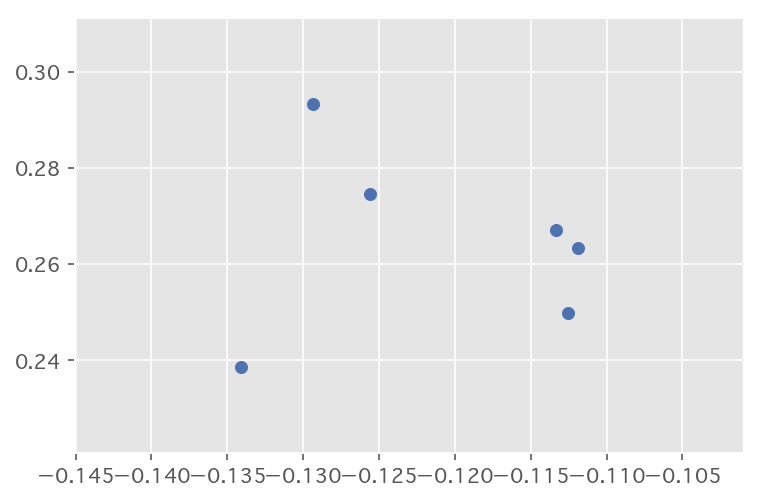

In [21]:
plt.scatter(diffs, stds)

In [25]:
diffs = []
stds = []
for team in central:
    lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(lst)[2].values, pd.DataFrame(lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(lst)[2].values, pd.DataFrame(lst)[[1]].values)
    std = make_score_df(team).describe()[column]["std"] #/ make_score_df(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy - first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy - first_cond_entropy, std)

広島 -0.13081643531445852 0.273583977405
ヤクルト -0.12723893097536543 0.255275207113
巨人 -0.11617775617173276 0.244355385206
ＤｅＮＡ -0.10359832007089587 0.247937972637
中日 -0.1198875209499195 0.251061251601
阪神 -0.11861437822777487 0.275359212424


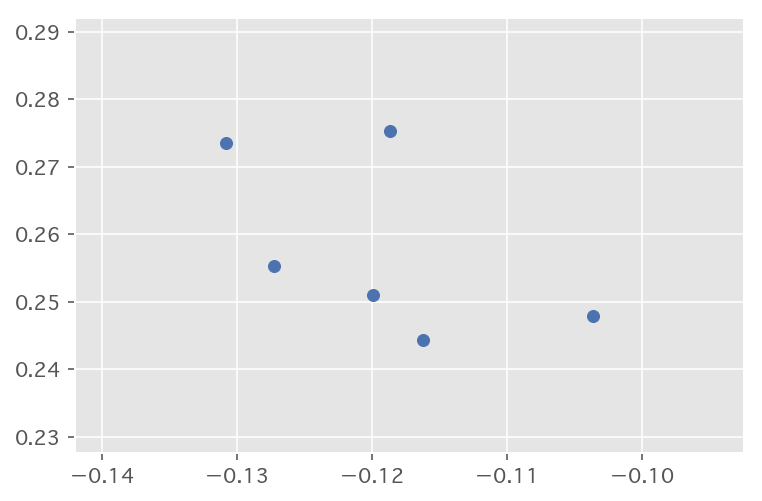

In [26]:
plt.scatter(diffs, stds)

# 得点で見るか失点で見るか / 安打数を入れてもいいかも
# 標準偏差をそのまま使うか / 変動係数を使うか

In [36]:
diffs = []
stds = []
for team in pacific+central:
    lst = make_flattened_list(make_inning_triple(make_inning_list(event_df[event_df.攻撃チーム==team])))
    # H(St+1 | St, St-1)
    second_cond_entropy = cond_entropy(pd.DataFrame(lst)[2].values, pd.DataFrame(lst)[[0, 1]].values)
    # H(St+1 | St)
    first_cond_entropy = cond_entropy(pd.DataFrame(lst)[2].values, pd.DataFrame(lst)[[1]].values)
    std = make_score_df(team).describe()[column]["std"] #/ make_score_df(team).describe()[column]["mean"]
    diffs.append(second_cond_entropy - first_cond_entropy)
    stds.append(std)
    print(team, second_cond_entropy - first_cond_entropy, std)

西武 -0.12936799438793356 3.46452910947
ソフトバンク -0.11255035082854281 3.19062218542
日本ハム -0.11188805896839593 2.99808120277
オリックス -0.1256219925195241 2.86439522962
ロッテ -0.13409313985255622 2.72549398464
楽天 -0.11332040265998611 2.87909948565
広島 -0.13081643531445852 3.1490932408
ヤクルト -0.12723893097536543 2.91726519115
巨人 -0.11617775617173276 3.27865168571
ＤｅＮＡ -0.10359832007089587 2.79709599974
中日 -0.1198875209499195 2.9345880116
阪神 -0.11861437822777487 3.62989803137


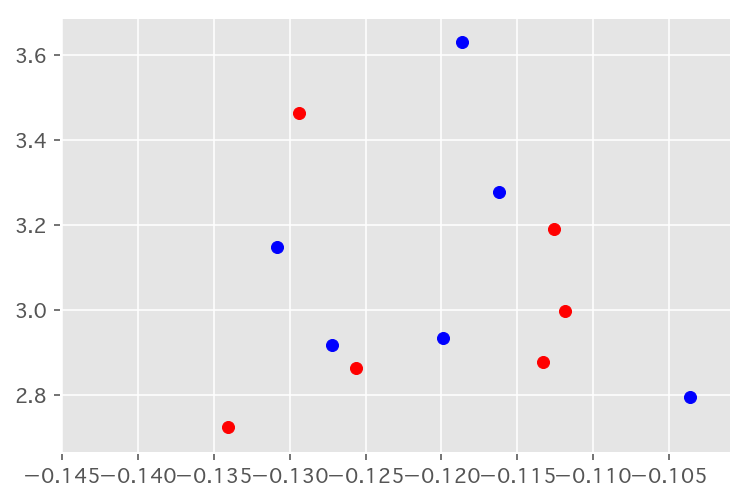

In [37]:
plt.scatter(diffs[:6], stds[:6], color="red")
plt.scatter(diffs[6:], stds[6:], color="blue")

In [38]:
import statsmodels.formula.api as smf

model = smf.OLS(stds, diffs)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     888.3
Date:                Fri, 23 Nov 2018   Prob (F-statistic):           7.16e-12
Time:                        01:50:26   Log-Likelihood:                -4.1065
No. Observations:                  12   AIC:                             10.21
Df Residuals:                      11   BIC:                             10.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -25.3897      0.852    -29.804      0.000     -27.265     -23.515
==============================================================================
Omnibus:                        0.316   Durbin-Watson:                   1.415
Prob(Omnibus):                  0.854   Jarque-Bera (JB):                0.238
Skew:                          -0.267   Prob(JB):                        0.888
Kurtosis:                       2.565   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# MLBでの使い方

In [41]:
files = os.listdir("/Users/konoharuki/Desktop/GitHub/baseball/game_detail_data_mlb")[1:]

In [53]:
res = []
for file in files:
    res.append(pd.read_csv("/Users/konoharuki/Desktop/GitHub/baseball/game_detail_data_mlb/"+file, encoding="cp932", dtype=str).values.tolist())

In [58]:
inning_list = []
for elem in res:
    inning_list.append(np.array(elem)[:, 1].tolist() + ["GAMESET"])

In [61]:
#make_flattened_list(make_inning_triple(inning_list))